In [1]:
import jax3dp3 as j
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [65]:
iter = 22
DATASET_FILENAME = f"tabletop_data_{iter}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")    

data = np.load(DATASET_FILE,allow_pickle=True)
original_intrinsics = j.Intrinsics(*data["intrinsics"])
intrinsics = j.camera.scale_camera_parameters(original_intrinsics, 0.1)
indices = jnp.array(data["indices"])
rgb = data["rgb"]
poses = jnp.array(data["poses"])
table_pose = jnp.array(data["table_pose"])
j.get_rgb_image(rgb)


renderer = j.Renderer(intrinsics)

model_dir = os.path.join(j.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path)

table_params = data["table_params"]
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]
renderer.add_mesh(table_mesh)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 512)


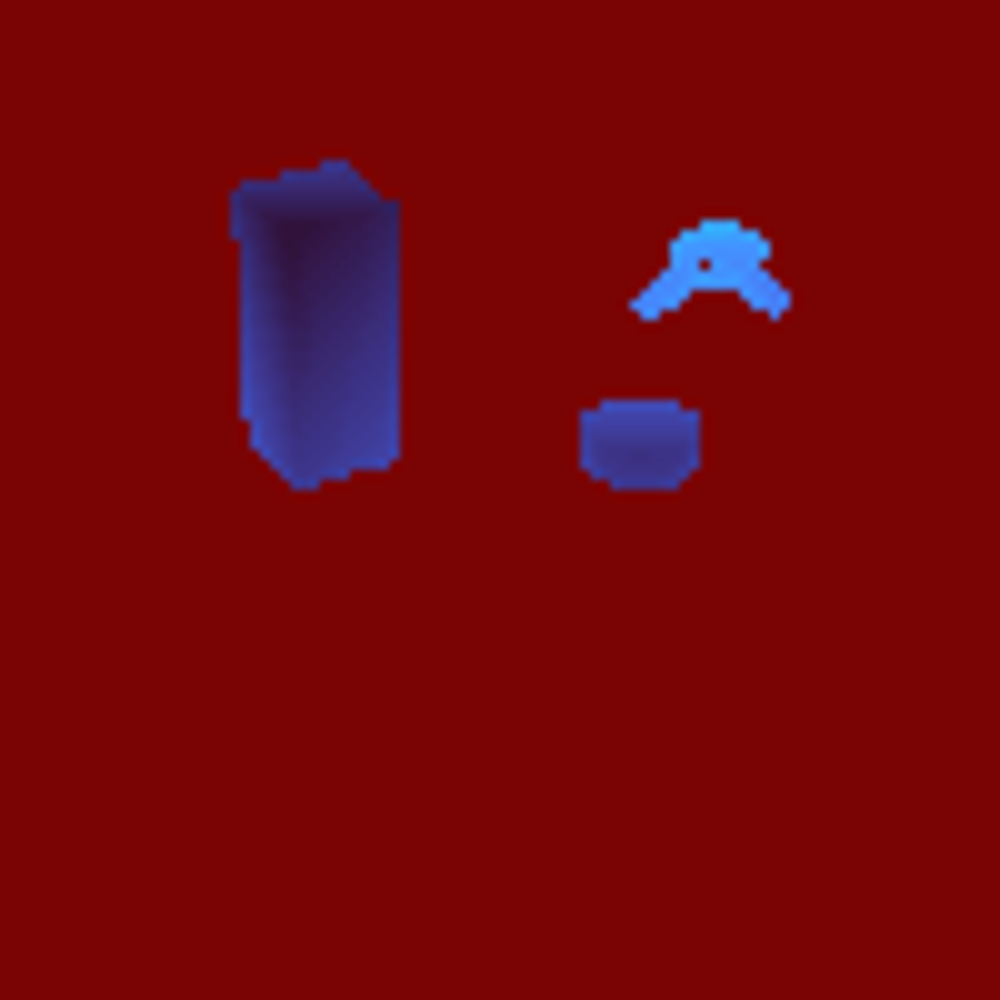

In [102]:
iter = 24
DATASET_FILENAME = f"tabletop_data_{iter}.npz"  # npz file
DATASET_FILE = os.path.join(j.utils.get_assets_dir(), f"datasets/{DATASET_FILENAME}")
    
data = np.load(DATASET_FILE,allow_pickle=True)
original_intrinsics = j.Intrinsics(*data["intrinsics"])
intrinsics = j.camera.scale_camera_parameters(original_intrinsics, 0.1)
indices = jnp.array(data["indices"])
rgb = data["rgb"]
poses = jnp.array(data["poses"])
table_pose = jnp.array(data["table_pose"])
j.get_rgb_image(rgb)


observed_point_cloud_image = renderer.render_multiobject(
    jnp.concatenate([poses, table_pose[None,:,:]]),
    jnp.concatenate([indices, jnp.array([21])])
)

observed_point_cloud_image = renderer.render_multiobject(
    jnp.concatenate([poses]),
    jnp.concatenate([indices])
)
# j.get_rgb_image(rgb)
# j.overlay_image(
#     j.get_rgb_image(rgb),
# )
j.get_rgb_image(rgb)

j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2],max=4000.0), 10)


In [116]:
R_SWEEP = jnp.array([200.0, 100.0, 30.0, 5.0, 1.0]).reshape(-1,1)
OUTLIER_PROBS = jnp.linspace(0.01, 0.3, 4)
OUTLIER_VOLUME = 1000.0**3
SCALING_FACTOR = 3

contact_param_gridding_schedule = [
    j.make_translation_grid_enumeration_3d(
        -200.0, -200.0, -jnp.pi,
        200.0, 200.0, jnp.pi,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -20.0, -20.0, -jnp.pi/5,
        20.0, 20.0, jnp.pi/5,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -2.0, -2.0, -jnp.pi/5/5,
        2.0, 2.0, jnp.pi/5/5,
        11,11,5
    ),
    j.make_translation_grid_enumeration_3d(
        -0.0, -0.0, -jnp.pi,
        0.0, 0.0, jnp.pi,
        1,1,7*7
    ),
    j.make_translation_grid_enumeration_3d(
        -0.5, -0.5, -jnp.pi/5/5,
        0.5, 0.5, jnp.pi/5/5,
        11,11,5
    ),

]

pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))


In [117]:
# R = jnp.array([0.1, 0.1])
# object_poses, object_ids = table_pose[None,:,:], [21]

R = jnp.array([0.5])
object_poses, object_ids = jnp.zeros((0,1,4,4)), []

In [123]:
all_hypotheses = []
for obj_id in range(10):
    print("Object Id : ", obj_id)
    contact_param = jnp.zeros(3)
    p = None
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param
        
        potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
            contact_param_grid,
            3,
            renderer.model_box_dims[obj_id],
            contact_plane
        )
        POTENTIAL_R = jnp.hstack([jnp.tile(R[None,:], (R_SWEEP.shape[0], 1)),R_SWEEP])

        potential_poses = jnp.concatenate(
            [
                jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                potential_new_object_poses[None,...]
            ]
        )
        reconstruction = renderer.render_multiobject_parallel(
            potential_poses, object_ids + [obj_id]
        )
        p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(
            observed_point_cloud_image, reconstruction[:,:,:,:3], reconstruction[:,:,:, -1],
            POTENTIAL_R, OUTLIER_PROBS, OUTLIER_VOLUME,
            3
        )
        ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
        contact_param = contact_param_grid[ii]
#         print(POTENTIAL_R[jj])

    best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_PROBS[kk])

    all_hypotheses.append(
        (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
    )

scores = jnp.array([i[0] for i in all_hypotheses])
print(j.utils.normalize_log_scores(scores))
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

R = best_r
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]



Object Id :  0
Object Id :  1
Object Id :  2
Object Id :  3
Object Id :  4
Object Id :  5
Object Id :  6
Object Id :  7
Object Id :  8
Object Id :  9
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 7.6054225e-16 0.0000000e+00 1.0000000e+00 0.0000000e+00 3.3631163e-44]
[7 5 9 0 2 4 8 3 1 6]
Best
[  0.5 200.    1.  200. ] 0.01 7


[  0.5 200.    1.  200. ]


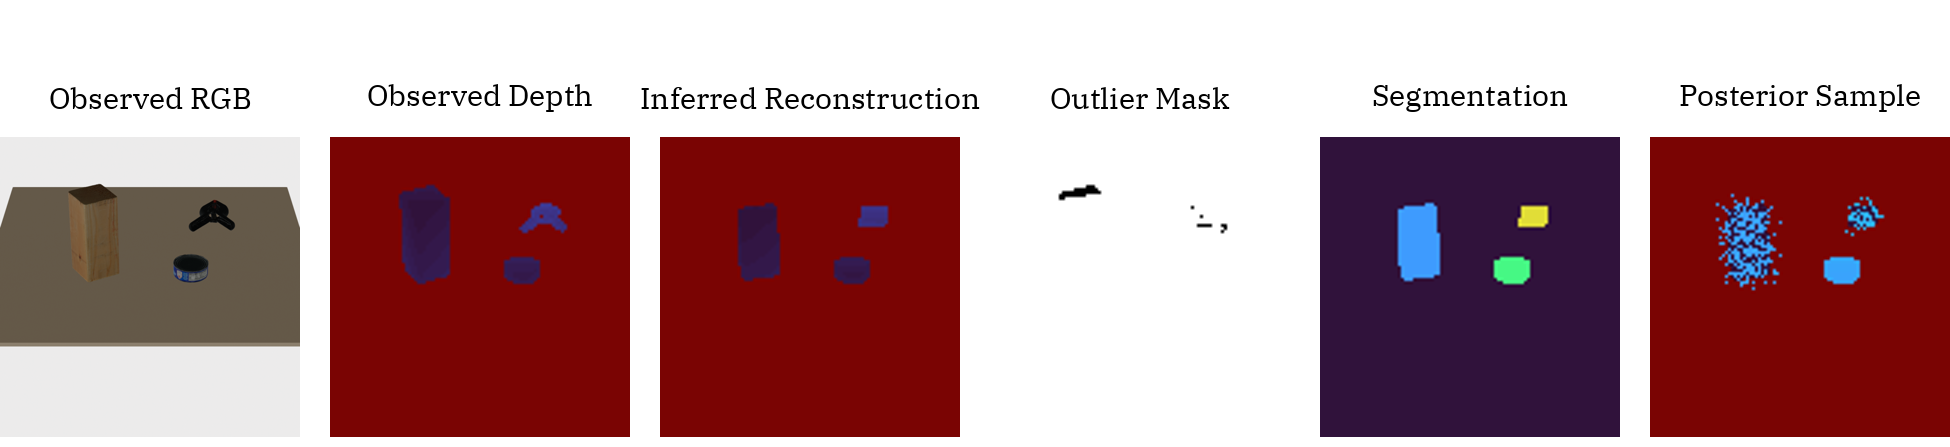

In [124]:
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)
inliers = (
    (jnp.log(1.0 - best_outlier_prob)  + j.threedp3_likelihood_multi_r_per_pixel_jit(
        observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r, 0.0, 1.0,3
    ))
        >
    jnp.log(best_outlier_prob / OUTLIER_VOLUME)
)

# height_factor = outlier_prob_viz.height / observed_image_viz.height


rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])
r_array = R
print(r_array, )
r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
key = jax.random.PRNGKey(12)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)


viz1 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["{:d} : {:0.3f}".format(idx, i[0].item()) for (idx,i) in enumerate(all_hypotheses)]
)
viz2 = j.multi_panel(
    [
        j.scale_image(j.get_rgb_image(rgb),SCALING_FACTOR/10),
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *inliers,cmap=plt.cm.gray), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,3], max=5.0), SCALING_FACTOR),
#         j.scale_image(j.get_depth_image(img[:,:,2],min=observed_point_cloud_image[:,:,2].min(),max=observed_point_cloud_image[:,:,2].max()), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(img[:,:,2]), SCALING_FACTOR),
    ],
    labels=[
        "Observed RGB",
        "Observed Depth",
        "Inferred Reconstruction",
        "Outlier Mask",
        "Segmentation",
        "Posterior Sample",
    ],
    middle_width=30
)

viz2

In [78]:
print(object_ids)
print(indices)

[15, 5, 18]
[18 15  5]
